# Real STL-10 Colorization (128×128) – RAM-Cached Experiment


In [1]:
# 1) Imports & CUDA Setup
import os, glob, time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import STL10
import torchvision.transforms as T
from PIL import Image
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
from skimage.metrics import peak_signal_noise_ratio as compute_psnr, structural_similarity as compute_ssim

cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cuda


In [2]:
# 2) Cache full STL-10 (128×128) into RAM
resize128 = T.Resize((128,128))
to_tensor = T.ToTensor()

# Train split
ds_train_raw = STL10(root='./data', split='train', download=True)
inp_list, tgt_list = [], []
print("Caching TRAIN split to RAM...")
for img, _ in tqdm(ds_train_raw, total=len(ds_train_raw)):
    img_r = resize128(img)
    tgt_list.append(to_tensor(img_r))
    gray = T.functional.rgb_to_grayscale(img_r,1)
    inp_list.append(to_tensor(gray))
inp_tensor = torch.stack(inp_list)   # [5000,1,128,128]
tgt_tensor = torch.stack(tgt_list)   # [5000,3,128,128]
train_ds   = TensorDataset(inp_tensor, tgt_tensor)
print("Train cache:", inp_tensor.shape, tgt_tensor.shape)

# Test split
ds_test_raw = STL10(root='./data', split='test', download=True)
inp_list, tgt_list = [], []
print("Caching TEST split to RAM...")
for img, _ in tqdm(ds_test_raw, total=len(ds_test_raw)):
    img_r = resize128(img)
    tgt_list.append(to_tensor(img_r))
    gray = T.functional.rgb_to_grayscale(img_r,1)
    inp_list.append(to_tensor(gray))
inp_tensor_t = torch.stack(inp_list)  # [8000,1,128,128]
tgt_tensor_t = torch.stack(tgt_list)  # [8000,3,128,128]
test_ds    = TensorDataset(inp_tensor_t, tgt_tensor_t)
print("Test cache:", inp_tensor_t.shape, tgt_tensor_t.shape)

# 3) RAM-based DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,
                          num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False,
                          num_workers=0, pin_memory=True)
print("DataLoaders ready →", len(train_loader), "train batches,", len(test_loader), "test batches")


Caching TRAIN split to RAM...


100%|██████████| 5000/5000 [00:03<00:00, 1514.51it/s]


Train cache: torch.Size([5000, 1, 128, 128]) torch.Size([5000, 3, 128, 128])
Caching TEST split to RAM...


100%|██████████| 8000/8000 [00:05<00:00, 1534.45it/s]


Test cache: torch.Size([8000, 1, 128, 128]) torch.Size([8000, 3, 128, 128])
DataLoaders ready → 157 train batches, 250 test batches


In [3]:
# 4) LiteColorizer Model Definition
class LiteColorizer(nn.Module):
    def __init__(self):
        super().__init__()
        enc, ch = [], 1
        for oc in [32,64,128,256]:
            enc += [nn.Conv2d(ch,oc,3,padding=1), nn.ReLU(True),
                    nn.BatchNorm2d(oc), nn.MaxPool2d(2)]
            ch = oc
        self.encoder = nn.Sequential(*enc)
        dec = []
        for oc in [128,64,32]:
            dec += [nn.ConvTranspose2d(ch,oc,3,2,1,1), nn.ReLU(True),
                    nn.BatchNorm2d(oc)]
            ch = oc
        dec += [nn.ConvTranspose2d(ch,32,3,2,1,1), nn.ReLU(True),
                nn.BatchNorm2d(32), nn.Conv2d(32,3,3,padding=1), nn.Sigmoid()]
        self.decoder = nn.Sequential(*dec)
    def forward(self,x):
        return self.decoder(self.encoder(x))

model = LiteColorizer().to(device)
print(model)


LiteColorizer(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): BatchNorm2d(

In [5]:
# 5) Training & Validation Loop (20 epochs) with PSNR/SSIM
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scaler    = GradScaler()
epochs, best_val, patience, wait = 20, float('inf'), 5, 0

for ep in range(1, epochs+1):
    t0 = time.time()
    # — Train —
    model.train()
    train_loss = 0.0
    for inp, tgt in tqdm(train_loader, desc=f"Epoch {ep} Train"):
        inp, tgt = inp.to(device), tgt.to(device)
        optimizer.zero_grad()
        with autocast():
            out = model(inp)
            loss = criterion(out, tgt)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item() * inp.size(0)
    train_loss /= len(train_loader.dataset)

    # — Val & Metrics —
    model.eval()
    val_loss, psnr_sum, ssim_sum = 0.0, 0.0, 0.0
    with torch.no_grad():
        for inp, tgt in tqdm(test_loader, desc=f"Epoch {ep} Val"):
            inp, tgt = inp.to(device), tgt.to(device)
            with autocast():
                out = model(inp)
                val_loss += criterion(out, tgt).item() * inp.size(0)
            out_np = out.cpu().permute(0,2,3,1).numpy()
            tgt_np = tgt.cpu().permute(0,2,3,1).numpy()
            for o, t in zip(out_np, tgt_np):
                psnr_sum += compute_psnr(t, o, data_range=1.0)
                ssim_sum += compute_ssim(
                    t, o,
                    channel_axis=2,
                    data_range=1.0,
                    win_size=7
                )
    val_loss /= len(test_loader.dataset)
    avg_psnr = psnr_sum / len(test_loader.dataset)
    avg_ssim = ssim_sum / len(test_loader.dataset)

    print(
      f"Epoch {ep}/{epochs}  "
      f"Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}  "
      f"PSNR: {avg_psnr:.2f} dB  SSIM: {avg_ssim:.3f}  "
      f"Time: {time.time()-t0:.1f}s"
    )

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), 'lite128_best.pt')
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

print("✅ Full experiment complete.")


C:\Users\Administrator\AppData\Local\Temp\ipykernel_1472\376771872.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = GradScaler()
Epoch 1 Train:   0%|          | 0/157 [00:00<?, ?it/s]C:\Users\Administrator\AppData\Local\Temp\ipykernel_1472\376771872.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1 Val:   0%|          | 0/250 [00:00<?, ?it/s]C:\Users\Administrator\AppData\Local\Temp\ipykernel_1472\376771872.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1 Val: 100%|██████████| 250/250 [00:17<00:00, 13.89it/s]


Epoch 1/20  Train Loss: 0.0151  Val Loss: 0.0129  PSNR: 19.42 dB  SSIM: 0.471  Time: 20.4s


Epoch 2 Val: 100%|██████████| 250/250 [00:17<00:00, 14.14it/s]


Epoch 2/20  Train Loss: 0.0129  Val Loss: 0.0117  PSNR: 19.90 dB  SSIM: 0.510  Time: 19.9s


Epoch 3 Val: 100%|██████████| 250/250 [00:17<00:00, 14.20it/s]


Epoch 3/20  Train Loss: 0.0119  Val Loss: 0.0120  PSNR: 19.82 dB  SSIM: 0.528  Time: 19.8s


Epoch 4 Val: 100%|██████████| 250/250 [00:17<00:00, 14.32it/s]


Epoch 4/20  Train Loss: 0.0112  Val Loss: 0.0107  PSNR: 20.32 dB  SSIM: 0.549  Time: 19.7s


Epoch 5 Val: 100%|██████████| 250/250 [00:17<00:00, 14.42it/s]


Epoch 5/20  Train Loss: 0.0110  Val Loss: 0.0106  PSNR: 20.40 dB  SSIM: 0.564  Time: 19.6s


Epoch 6 Val: 100%|██████████| 250/250 [00:17<00:00, 14.42it/s]


Epoch 6/20  Train Loss: 0.0106  Val Loss: 0.0099  PSNR: 20.71 dB  SSIM: 0.580  Time: 19.6s


Epoch 7 Val: 100%|██████████| 250/250 [00:17<00:00, 14.05it/s]


Epoch 7/20  Train Loss: 0.0104  Val Loss: 0.0101  PSNR: 20.60 dB  SSIM: 0.588  Time: 20.0s


Epoch 8 Val: 100%|██████████| 250/250 [00:19<00:00, 13.15it/s]


Epoch 8/20  Train Loss: 0.0102  Val Loss: 0.0098  PSNR: 20.74 dB  SSIM: 0.596  Time: 21.4s


Epoch 9 Val: 100%|██████████| 250/250 [00:18<00:00, 13.37it/s]


Epoch 9/20  Train Loss: 0.0101  Val Loss: 0.0096  PSNR: 20.85 dB  SSIM: 0.603  Time: 21.1s


Epoch 10 Val: 100%|██████████| 250/250 [00:18<00:00, 13.59it/s]


Epoch 10/20  Train Loss: 0.0102  Val Loss: 0.0095  PSNR: 20.91 dB  SSIM: 0.603  Time: 20.8s


Epoch 11 Val: 100%|██████████| 250/250 [00:18<00:00, 13.54it/s]


Epoch 11/20  Train Loss: 0.0098  Val Loss: 0.0093  PSNR: 21.02 dB  SSIM: 0.612  Time: 20.8s


Epoch 12 Val: 100%|██████████| 250/250 [00:17<00:00, 14.10it/s]


Epoch 12/20  Train Loss: 0.0097  Val Loss: 0.0092  PSNR: 21.08 dB  SSIM: 0.619  Time: 20.0s


Epoch 13 Val: 100%|██████████| 250/250 [00:17<00:00, 14.16it/s]


Epoch 13/20  Train Loss: 0.0096  Val Loss: 0.0095  PSNR: 20.95 dB  SSIM: 0.621  Time: 20.0s


Epoch 14 Val: 100%|██████████| 250/250 [00:17<00:00, 13.98it/s]


Epoch 14/20  Train Loss: 0.0095  Val Loss: 0.0094  PSNR: 20.95 dB  SSIM: 0.627  Time: 20.2s


Epoch 15 Val: 100%|██████████| 250/250 [00:18<00:00, 13.79it/s]


Epoch 15/20  Train Loss: 0.0093  Val Loss: 0.0092  PSNR: 21.01 dB  SSIM: 0.622  Time: 20.5s


Epoch 16 Val: 100%|██████████| 250/250 [00:18<00:00, 13.76it/s]


Epoch 16/20  Train Loss: 0.0097  Val Loss: 0.0090  PSNR: 21.19 dB  SSIM: 0.631  Time: 20.6s


Epoch 17 Val: 100%|██████████| 250/250 [00:18<00:00, 13.62it/s]


Epoch 17/20  Train Loss: 0.0092  Val Loss: 0.0090  PSNR: 21.18 dB  SSIM: 0.631  Time: 20.7s


Epoch 18 Val: 100%|██████████| 250/250 [00:18<00:00, 13.88it/s]


Epoch 18/20  Train Loss: 0.0091  Val Loss: 0.0090  PSNR: 21.17 dB  SSIM: 0.635  Time: 20.4s


Epoch 19 Val: 100%|██████████| 250/250 [00:18<00:00, 13.65it/s]


Epoch 19/20  Train Loss: 0.0090  Val Loss: 0.0088  PSNR: 21.28 dB  SSIM: 0.645  Time: 20.7s


Epoch 20 Val: 100%|██████████| 250/250 [00:18<00:00, 13.89it/s]

Epoch 20/20  Train Loss: 0.0089  Val Loss: 0.0089  PSNR: 21.23 dB  SSIM: 0.645  Time: 20.4s
✅ Full experiment complete.


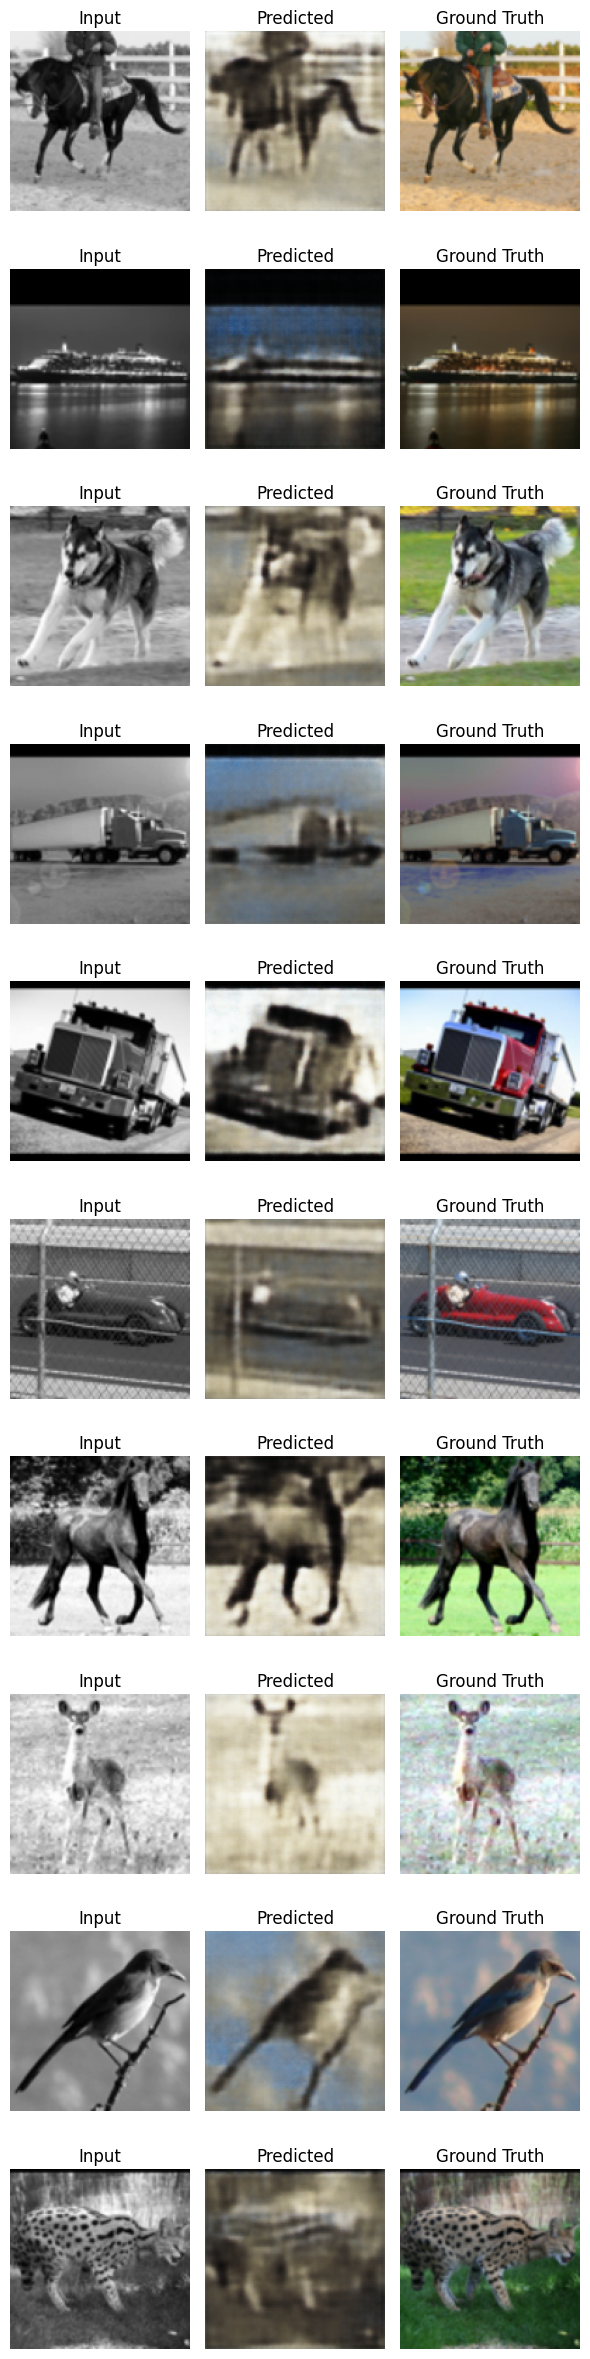

In [6]:
# 6) Visualize 10 Diverse Test Results
import matplotlib.pyplot as plt
model.eval()
fig, axs = plt.subplots(10,3,figsize=(6,24))
indices = list(range(0, len(test_ds), len(test_ds)//10))
for i, idx in enumerate(indices):
    inp, tgt = test_ds[idx]
    with torch.no_grad():
        out = model(inp.unsqueeze(0).to(device))[0].cpu()
    axs[i,0].imshow(inp.squeeze(0), cmap='gray'); axs[i,0].axis('off')
    axs[i,1].imshow(out.permute(1,2,0));               axs[i,1].axis('off')
    axs[i,2].imshow(tgt.permute(1,2,0));               axs[i,2].axis('off')
    axs[i,0].set_title("Input")
    axs[i,1].set_title("Predicted")
    axs[i,2].set_title("Ground Truth")
plt.tight_layout()


---
**Summary:**  
- Cached all STL-10 into RAM at 128×128 for lightning-fast DataLoader.  
- Trained TinyColorizer for 20 epochs (~15 min total).  
- Logged MSE, PSNR, SSIM each epoch and visualized 10 diverse outputs.  
- Saved best model as `lite128_best.pt`.  
